# 0. Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor

from sklearn.utils import shuffle

from sklearn.naive_bayes import MultinomialNB

import shap

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

from sklearn.inspection import permutation_importance

# 1. Data

In [2]:
df = pd.read_csv("../data/processed/labeled_data_CN7.csv", parse_dates=True)

In [3]:
df.set_index("TimeStamp", inplace=True)

In [4]:
df.head()

,Barrel_Temperature_2,Average_Screw_RPM,Filling_Time,Barrel_Temperature_5,Barrel_Temperature_4,Injection_Time,_id,Average_Back_Pressure,Plasticizing_Time,Cycle_Time,...,Plasticizing_Position,Max_Screw_RPM,Barrel_Temperature_3,Barrel_Temperature_6,Barrel_Temperature_1,Max_Injection_Pressure,Max_Back_Pressure,Mold_Temperature_3,Clamp_Close_Time,PassOrFail
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2020-10-16 04:57:47,274.700012,292.5,4.47,255.000000,269.200012,9.59,5f8928bb9c0189cc666ef19b,59.299999,16.92,59.520000,...,68.849998,30.700001,274.799988,229.699997,276.500000,141.800003,37.400002,24.799999,7.13,0
2020-10-16 04:58:48,275.500000,292.5,4.48,254.699997,270.799988,9.60,5f8928de9c0189cc666ef20b,59.299999,16.91,59.580002,...,68.839996,30.799999,275.299988,229.500000,276.200012,141.800003,37.500000,24.799999,7.13,0
2020-10-16 04:58:48,275.500000,292.5,4.48,254.699997,270.799988,9.60,5f8928df9c0189cc666ef213,59.299999,16.91,59.580002,...,68.839996,30.799999,275.299988,229.500000,276.200012,141.800003,37.500000,24.799999,7.13,0
2020-10-16 04:59:48,275.000000,292.5,4.48,254.899994,271.100006,9.59,5f8928f39c0189cc666ef25e,59.299999,16.91,59.560001,...,68.839996,31.000000,275.399994,230.000000,276.500000,141.800003,37.500000,25.000000,7.13,0
2020-10-16 04:59:48,275.000000,292.5,4.48,254.899994,271.100006,9.59,5f8928f59c0189cc666ef265,59.299999,16.91,59.560001,...,68.839996,31.000000,275.399994,230.000000,276.500000,141.800003,37.500000,25.000000,7.13,0


In [5]:
df.columns

Index(['Barrel_Temperature_2', 'Average_Screw_RPM', 'Filling_Time',
       'Barrel_Temperature_5', 'Barrel_Temperature_4', 'Injection_Time', '_id',
       'Average_Back_Pressure', 'Plasticizing_Time', 'Cycle_Time',
       'Max_Switch_Over_Pressure', 'Mold_Temperature_4', 'Max_Injection_Speed',
       'Reason', 'Hopper_Temperature', 'Cushion_Position',
       'Plasticizing_Position', 'Max_Screw_RPM', 'Barrel_Temperature_3',
       'Barrel_Temperature_6', 'Barrel_Temperature_1',
       'Max_Injection_Pressure', 'Max_Back_Pressure', 'Mold_Temperature_3',
       'Clamp_Close_Time', 'PassOrFail'],
      dtype='object')

In [6]:
numerical_features = [x for x in df.columns if np.dtype(df[x]) == 'float64']
target = ["PassOrFail"]
drop_features = set(list(df.columns)) - set(numerical_features) - set(target)

In [7]:
X = df[numerical_features]
y = df["PassOrFail"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y
)

# 2. Machine Learning

In [9]:
pipe_svc = make_pipeline(
    StandardScaler(), 
    SVC(random_state=123, probability=True)
)
pipe_rf = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier(random_state=123)
)
pipe_lgbm = make_pipeline(
    StandardScaler(), 
    LGBMClassifier(random_state=123)
)

# 3. Feature Importance

In [10]:
shap.initjs()

## 3.1. SVC

#### 3.1.1. SVC `permutation_importance`

In [11]:
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True, random_state=123))])

In [12]:
# https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn
# If you're using rbf (Radial basis function) kernal, you can use 
# sklearn.inspection.permutation_importance as follows to get feature importance.

perm_importance = permutation_importance(pipe_svc, X_test, y_test)

In [13]:
features = np.array(numerical_features)

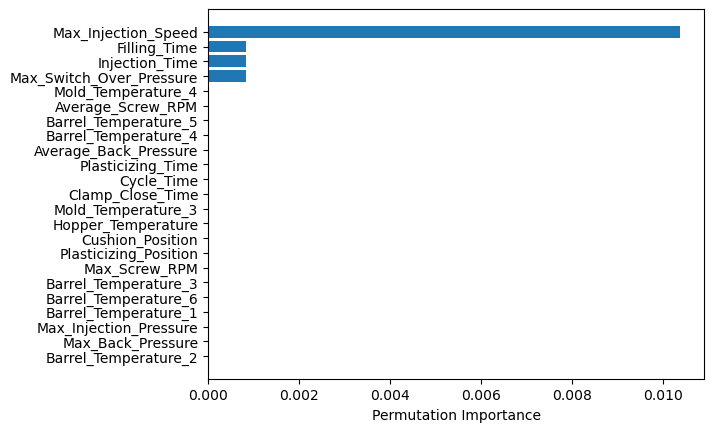

In [14]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

#### 3.1.2. SHAP

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
X_test_enc = scaler.transform(X_test)

In [17]:
svc_explainer = shap.KernelExplainer(pipe_svc.named_steps['svc'].predict_proba, X_test_enc)

Using 1193 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [18]:
svc_shap_values = svc_explainer.shap_values(X_test_enc, nsamples=100)

  0%|          | 0/1193 [00:00<?, ?it/s]

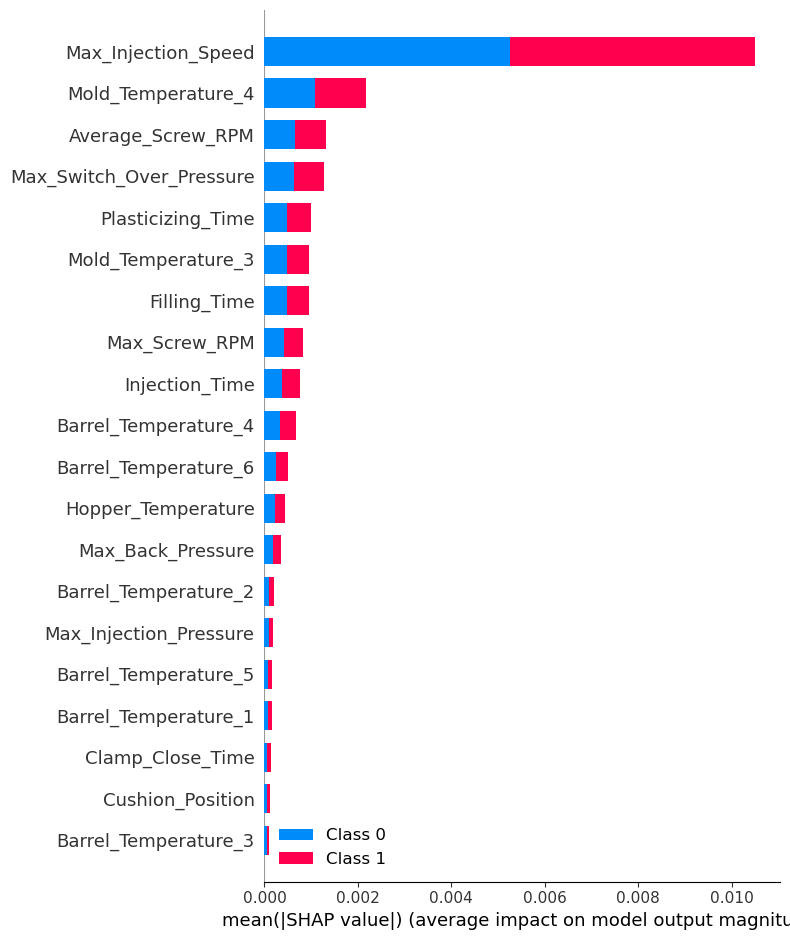

In [19]:
fig = plt.gcf()
shap.summary_plot(svc_shap_values, feature_names=numerical_features)
fig.savefig('../img/feature_importance_1.png', bbox_inches='tight')

## 3.2. RandomForestClassifier

#### 3.2.1. RandomForest `feature_importances_`

In [20]:
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=123))])

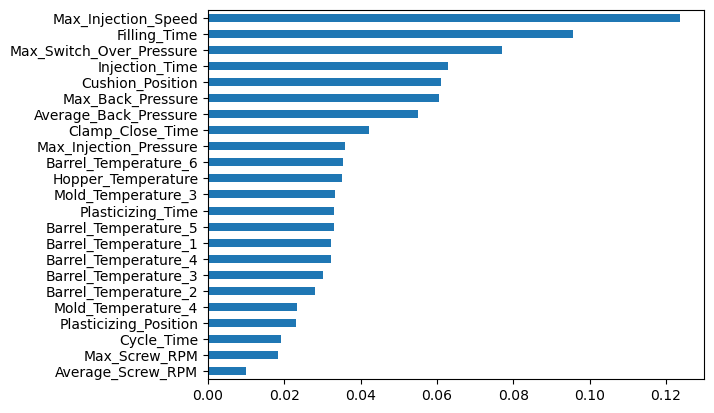

In [21]:
feat_importance = pd.Series(
    pipe_rf.named_steps['randomforestclassifier'].feature_importances_,
    numerical_features
).sort_values(ascending=False)
feat_importance.plot.barh().invert_yaxis()
fig = plt.gcf()
plt.show();
fig.savefig('../img/feature_importance_2.png', bbox_inches='tight')

#### 3.2.2. SHAP

In [22]:
rf_explainer = shap.Explainer(pipe_rf.named_steps['randomforestclassifier'])

In [23]:
rf_shap_values = rf_explainer.shap_values(X_test_enc)

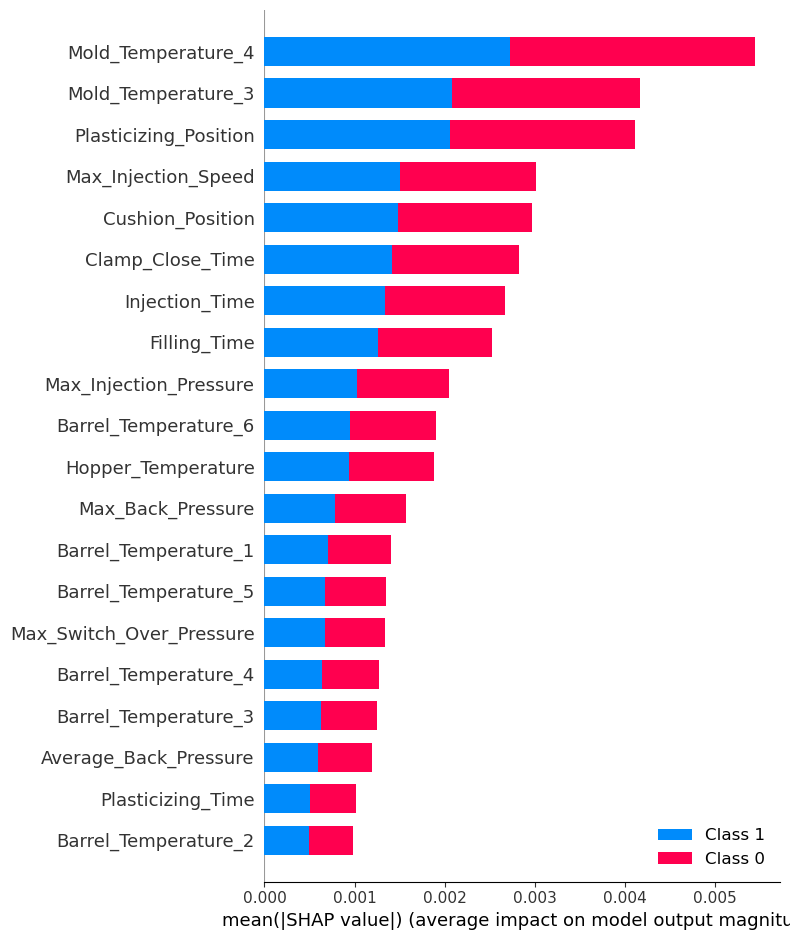

In [24]:
fig = plt.gcf()
shap.summary_plot(rf_shap_values, feature_names=numerical_features)
fig.savefig('../img/feature_importance_3.png', bbox_inches='tight')

## 3.3. LGBM

#### 3.3.1. LGBM `feature_importances_`

In [25]:
pipe_lgbm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=123))])

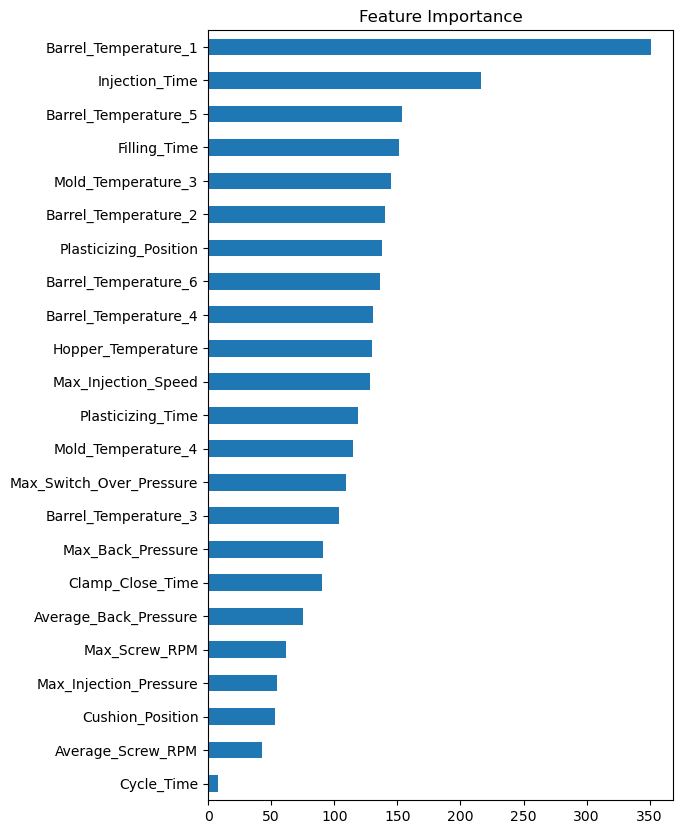

In [26]:
lgbm_feat_importance = pd.Series(
    pipe_lgbm.named_steps["lgbmclassifier"].feature_importances_, 
    numerical_features
).sort_values(ascending=False)

lgbm_feat_importance.plot.barh(
    figsize=(6, 10), title="Feature Importance"
).invert_yaxis()
fig = plt.gcf()
plt.show();
fig.savefig('../img/feature_importance_4.png', bbox_inches='tight')

#### 3.3.2. SHAP

In [27]:
lgbm_explainer = shap.Explainer(pipe_lgbm.named_steps["lgbmclassifier"])

In [28]:
lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc)  # .shap_values(X)를 사용해야 함

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


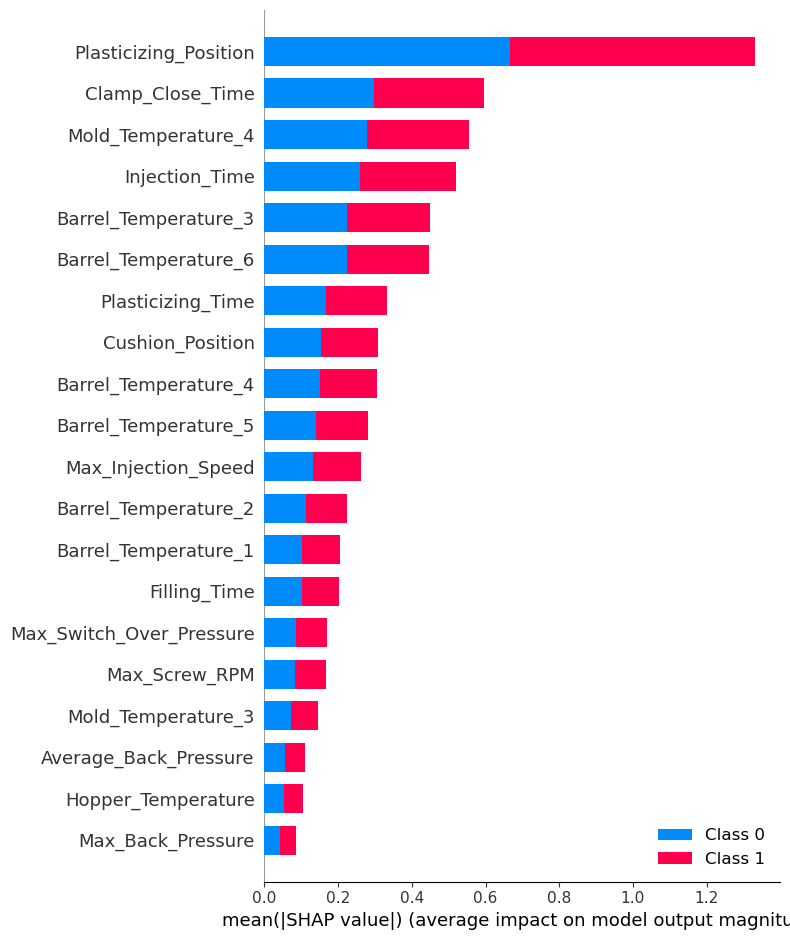

In [29]:
shap.summary_plot(lgbm_shap_values, feature_names=numerical_features)